In [1]:
%load_ext autoreload
%autoreload 2

import gc
import logging
import os
import pickle
import sys

import anndata as ad
import numpy as np
import torch
import pandas as pd
import scanpy as sc
import scipy
import yaml
import scipy.sparse as sps
import scipy.io as sio
from os.path import join

import scglue
import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

In [2]:
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'

In [3]:
# Path to the data directory
root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
data_dir = "/home/yanxh/data/Seurat_demo_data/bm_cite"

par = {}
par['input_pretrain'] = os.path.join(
    root_dir, 
    'output/pretrain/clue/bm_cite_donorSplit.clue_train.output_pretrain/')
par['output_pretrain'] = par['input_pretrain']

In [4]:
sys.path.append(os.path.join(root_dir, 'src/match_modality/methods/clue/resources'))
import utils

In [5]:
print('Reading `mtx` files...')
rna_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_mat_count.mtx')).T)
adt_count_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'adt_mat_count.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
adt_names = pd.read_csv(join(data_dir, 'adt_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data['batch'] = meta_data.donor.to_numpy()

train_idx = np.where((meta_data.batch=='batch1').to_numpy())[0]
test_idx  = np.where((meta_data.batch=='batch2').to_numpy())[0]

rna_count_mat.shape, adt_count_mat.shape, train_idx.size, test_idx.size

Reading `mtx` files...


((30672, 17009), (30672, 25), 14468, 16204)

In [6]:
print('Reading `h5ad` files...')
input_train_mod1 = sc.AnnData(sps.csr_matrix(rna_count_mat[train_idx]), obs=meta_data.iloc[train_idx])
input_train_mod2 = sc.AnnData(sps.csr_matrix(adt_count_mat[train_idx]), obs=meta_data.iloc[train_idx])
input_test_mod1 = sc.AnnData(sps.csr_matrix(rna_count_mat[test_idx]), obs=meta_data.iloc[test_idx])
input_test_mod2 = sc.AnnData(sps.csr_matrix(adt_count_mat[test_idx]), obs=meta_data.iloc[test_idx])

# set var names
input_train_mod1.var_names = input_test_mod1.var_names = rna_names
input_train_mod2.var_names = input_test_mod2.var_names = adt_names

# set counts
input_train_mod1.layers["counts"] = input_train_mod1.X.astype(np.float32)
input_train_mod2.layers["counts"] = input_train_mod2.X.astype(np.float32)
input_test_mod1.layers["counts"] = input_test_mod1.X.astype(np.float32)
input_test_mod2.layers["counts"] = input_test_mod2.X.astype(np.float32)

mod1_feature_type = 'GEX'
mod2_feature_type = 'ADT'

Reading `h5ad` files...


### Shuffling test data

In [7]:
test_shuffle_idx1 = np.arange(input_test_mod1.shape[0])
np.random.shuffle(test_shuffle_idx1)
test_reorder_idx1 = np.argsort(test_shuffle_idx1)

test_shuffle_idx2 = np.arange(input_test_mod2.shape[0])
np.random.shuffle(test_shuffle_idx2)
test_reorder_idx2 = np.argsort(test_shuffle_idx2)

In [8]:
input_test_mod1 = input_test_mod1[test_shuffle_idx1].copy()
input_test_mod2 = input_test_mod2[test_shuffle_idx2].copy()

In [9]:
input_train_mod1.obs["uid"] = [f"train-{i}" for i in range(input_train_mod1.shape[0])]
input_train_mod2.obs["uid"] = [f"train-{i}" for i in range(input_train_mod2.shape[0])]
input_test_mod1.obs["uid"] = [f"test-mod1-{i}" for i in range(input_test_mod1.shape[0])]
input_test_mod2.obs["uid"] = [f"test-mod2-{i}" for i in range(input_test_mod2.shape[0])]
input_test_mod1.obs_names = [f"{mod1_feature_type}-{i}" for i in input_test_mod1.obs_names.to_numpy()]
input_test_mod2.obs_names = [f"{mod2_feature_type}-{i}" for i in input_test_mod2.obs_names.to_numpy()]

# assert np.all(input_train_mod1.obs["batch"] == input_train_mod2.obs["batch"])

In [10]:
if {mod1_feature_type, mod2_feature_type} == {"GEX", "ATAC"}:
    omics = "multiome"
elif {mod1_feature_type, mod2_feature_type} == {"GEX", "ADT"}:
    omics = "cite"
else:
    raise RuntimeError("Unrecognized modality!")

In [11]:
logging.info('Concatenating training and test data...')
input_mod1 = ad.concat(
    {"train": input_train_mod1, "test": input_test_mod1},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod1.uns["feature_type"] = mod1_feature_type
del input_train_mod1, input_test_mod1
gc.collect()
input_mod2 = ad.concat(
    {"train": input_train_mod2, "test": input_test_mod2},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod2.uns["feature_type"] = mod2_feature_type
del input_train_mod2, input_test_mod2
gc.collect()

INFO:root:Concatenating training and test data...


135

In [12]:
if mod1_feature_type == "GEX":
    gex, other = input_mod1, input_mod2
elif mod2_feature_type == "GEX":
    gex, other = input_mod2, input_mod1

In [13]:
logging.info('Reading preprocessors...')
with open(os.path.join(
        par['input_pretrain'], "prep.pickle"
), "rb") as f:
    prep = pickle.load(f)
    gex_prep = prep["gex_prep"]
    other_prep = prep["other_prep"]

INFO:root:Reading preprocessors...


In [14]:
logging.info('Preprocessing...')
if False:
    gex_missing = set(gex_prep.params["features"]).difference(gex.var_names)
    gex = ad.concat([gex, ad.AnnData(
        X=scipy.sparse.csr_matrix((gex.n_obs, len(gex_missing)), dtype=gex.X.dtype),
        obs=gex.obs, var=pd.DataFrame(index=list(gex_missing)),
        layers={"counts": scipy.sparse.csr_matrix((gex.n_obs, len(gex_missing)), dtype=gex.layers["counts"].dtype)}
    )], axis=1, merge="same", uns_merge="first")
    other_missing = set(other_prep.params["features"]).difference(other.var_names)
    other = ad.concat([other, ad.AnnData(
        X=scipy.sparse.csr_matrix((other.n_obs, len(other_missing)), dtype=other.X.dtype),
        obs=other.obs, var=pd.DataFrame(index=list(other_missing)),
        layers={"counts": scipy.sparse.csr_matrix((other.n_obs, len(other_missing)), dtype=other.layers["counts"].dtype)}
    )], axis=1, merge="same", uns_merge="first")
    if input_mod1.uns["feature_type"] == "GEX":
        input_mod1, input_mod2 = gex, other
    else:  # input_mod2.uns["feature_type"] == "GEX":
        input_mod2, input_mod1 = gex, other
gex_prep.transform(gex)
other_prep.transform(other)

INFO:root:Preprocessing...


### Configure datasets

In [15]:
logging.info('Fine-tuning model...')
scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi" if other.uns["feature_type"] == "ATAC" else "X_pca",
    use_batch="batch", use_uid="uid"
)

INFO:root:Fine-tuning model...


In [16]:
with open(os.path.join(
        par['input_pretrain'], "hyperparams.yaml"
), "r") as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)

logging.info('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=hyperparams["latent_dim"],
    x2u_h_depth=hyperparams["x2u_h_depth"],
    x2u_h_dim=hyperparams["x2u_h_dim"],
    u2x_h_depth=hyperparams["u2x_h_depth"],
    u2x_h_dim=hyperparams["u2x_h_dim"],
    du_h_depth=hyperparams["du_h_depth"],
    du_h_dim=hyperparams["du_h_dim"],
    dropout=hyperparams["dropout"],
    shared_batches=True,
    random_seed=hyperparams["random_seed"]
)
print(model.net)


INFO:root:Building model...


[INFO] autodevice: Using GPU 0 as computation device.


INFO:autodevice:Using GPU 0 as computation device.


SCCLUE(
  (x2u): ModuleDict(
    (gex): NBCompositeDataEncoder(
      (encoders): ModuleList(
        (0): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (bn_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_0): Dropout(p=0.2, inplace=False)
          (linear_1): Linear(in_features=512, out_features=512, bias=True)
          (act_1): LeakyReLU(negative_slope=0.2)
          (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout_1): Dropout(p=0.2, inplace=False)
          (loc): Linear(in_features=512, out_features=20, bias=True)
          (std_lin): Linear(in_features=512, out_features=20, bias=True)
        )
        (1): ElementDataEncoder(
          (linear_0): Linear(in_features=100, out_features=512, bias=True)
          (act_0): LeakyReLU(negative_slope=0.2)
          (b

In [17]:
logging.info('Adopting pretrained weights...')
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    par['input_pretrain'], "pretrain.dill"
)))

INFO:root:Adopting pretrained weights...


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [18]:
logging.info('Compiling model...')
model.compile(
    lam_data=hyperparams["lam_data"],
    lam_kl=hyperparams["lam_kl"],
    lam_align=hyperparams["lam_align"],
    lam_cross=hyperparams["lam_cross"],
    lam_cos=hyperparams["lam_cos"],
    normalize_u=hyperparams["normalize_u"],
    domain_weight={"gex": 1, "other": 1},
    lr=1e-3  # TODO: Fine-tuning learning rate
)

INFO:root:Compiling model...


In [19]:
if False:
    logging.info('Training model...')
    model.fit(
        {"gex": gex, "other": other},
        align_burnin=0, max_epochs=50,  # 50 or 5
        patience=8, reduce_lr_patience=3
    )

    model.save(os.path.join(par['input_pretrain'], "train.dill"))
else:
    model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
        par['input_pretrain'], "train.dill"
    )))

[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: linear_1.weight


INFO:BatchedTransferrable:Copied: linear_1.weight


[INFO] BatchedTransferrable: Copied: linear_1.bias


INFO:BatchedTransferrable:Copied: linear_1.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


In [ ]:
# model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
#     par['input_pretrain'], "train.dill"
# )))

In [ ]:
# logging.info('Projecting cell embeddings...')
# gex.obsm["X_model"] = modela.encode_data("gex", gex)
# other.obsm["X_model"] = model.encode_data("other", other)

# Evaluation

In [20]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_specific_mod, eval_bridge, print_results, eval_asw, eval_lisi, eval_clustering

In [21]:
mod1_enc = model.encode_data('gex' if mod1_feature_type=='GEX' else 'other', input_mod1[input_mod1.obs["group"] == "test"])
mod2_enc = model.encode_data('gex' if mod2_feature_type=='GEX' else 'other', input_mod2[input_mod2.obs["group"] == "test"])

mod1_train_enc = model.encode_data('gex' if mod1_feature_type=='GEX' else 'other', input_mod1[input_mod1.obs["group"] == "train"])
mod2_train_enc = model.encode_data('gex' if mod2_feature_type=='GEX' else 'other', input_mod2[input_mod2.obs["group"] == "train"])

In [22]:
input_test_mod1 = input_mod1[input_mod1.obs["group"] == "test"].copy()
input_test_mod2 = input_mod2[input_mod2.obs["group"] == "test"].copy()
input_train_mod1 = input_mod1[input_mod1.obs["group"] == "train"].copy()
input_train_mod2 = input_mod2[input_mod2.obs["group"] == "train"].copy() 

In [23]:
input_test_mod1.obsm['X_model'] = mod1_enc
input_test_mod2.obsm['X_model'] = mod2_enc
input_train_mod1.obsm['X_model'] = mod1_train_enc
input_train_mod2.obsm['X_model'] = mod2_train_enc

input_train_mod1.obs['domain'] = 'multiome'; input_test_mod1.obs['domain'] = 'GEX';
input_train_mod2.obs['domain'] = 'multiome'; input_test_mod2.obs['domain'] = 'ADT';

input_train_mod1.obs['mod-batch'] = input_train_mod1.obs.batch.apply(lambda x: mod1_feature_type+'-'+x).to_numpy()
input_train_mod2.obs['mod-batch'] = input_train_mod2.obs.batch.apply(lambda x: mod2_feature_type+'-'+x).to_numpy()
input_test_mod1.obs['mod-batch'] = input_test_mod1.obs.batch.apply(lambda x: mod1_feature_type+'-'+x).to_numpy()
input_test_mod2.obs['mod-batch'] = input_test_mod2.obs.batch.apply(lambda x: mod2_feature_type+'-'+x).to_numpy()

## Reorder test data

In [24]:
input_test_mod1 = input_test_mod1[test_reorder_idx1].copy()
input_test_mod2 = input_test_mod2[test_reorder_idx2].copy()

In [25]:
mod1_test_ids = np.array([_.split("-", 1)[1] for _ in input_test_mod1.obs_names])
mod2_test_ids = np.array([_.split("-", 1)[1] for _ in input_test_mod2.obs_names])

assert (mod1_test_ids==mod2_test_ids).all()

In [26]:
def get_umap(adata, use_rep='X_model'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

### (1) Mosaic eval

In [29]:
mod1_feature_type, mod2_feature_type

('GEX', 'ADT')

## 1.1 without harmony

In [32]:
ad_train_mean_enc = sc.AnnData(
    (input_train_mod1.obsm['X_model'] + input_train_mod2.obsm['X_model'])/2, 
    obs=input_train_mod1.obs.copy()
)
ad_train_mean_enc.obsm['X_model'] = ad_train_mean_enc.X.copy()
ad_mosaic = sc.concat([ad_train_mean_enc, input_test_mod1, input_test_mod2])

r = eval_mosaic(ad_mosaic, label_key='celltype.l2', 
                lisi_keys=['mod-batch', 'domain'], use_rep='X_model', use_lisi=True, use_gc=False)

mod-batch_LISI=0.73922
domain_LISI=0.73922
NMI=0.78750
ARI=0.77165


In [33]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='celltype.l2', cluster_key='cluster', resolutions=None, use_rep='X_model',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.7910645658544123, 0.768795064075172)

In [34]:
r = eval_bridge(
        input_test_mod1, input_test_mod2,
        label_key='celltype.l2',
        batch_key='batch',
        use_rep='X_model',
        use_acc=False
)

FOSCTTM=0.07092
Match_score=0.00389


## 1.2 with harmony

In [27]:
from preprocessing import harmony

In [30]:
ad_train_mean_enc = sc.AnnData(
    (input_train_mod1.obsm['X_model'] + input_train_mod2.obsm['X_model'])/2, 
    obs=input_train_mod1.obs.copy()
)
ad_train_mean_enc.obsm['X_model'] = ad_train_mean_enc.X.copy()
ad_mosaic = sc.concat([ad_train_mean_enc, input_test_mod1, input_test_mod2])

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_model'], index=ad_mosaic.obs_names.to_numpy())
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]

r = eval_mosaic(ad_mosaic, label_key='celltype.l2', lisi_keys=['mod-batch'], use_rep='X_model_harmony', 
                use_lisi=True, use_gc=False, use_nmi=False)

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


mod-batch_LISI=0.78777


In [32]:
nmi, ari = eval_clustering(
    ad_mosaic, label_key='celltype.l2', cluster_key='cluster', resolutions=None, use_rep='X_model_harmony',
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.7871410436019097, 0.7576113025950814)

In [33]:
input_test_mod1.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][ad_train_mean_enc.shape[0]:(ad_train_mean_enc.shape[0] + input_test_mod1.shape[0])]
input_test_mod2.obsm['X_model_harmony'] = ad_mosaic.obsm['X_model_harmony'][-input_test_mod2.shape[0]:]

r = eval_bridge(
        input_test_mod1, input_test_mod2,
        label_key='celltype.l2',
        batch_key='batch',
        use_rep='X_model_harmony',
        use_acc=False
)

FOSCTTM=0.07042
Match_score=0.00311


# Vis

In [28]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [29]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [30]:
ad_train_mean_enc = sc.AnnData(
    (input_train_mod1.obsm['X_model'] + input_train_mod2.obsm['X_model'])/2, 
    obs=input_train_mod1.obs.copy()
)
ad_train_mean_enc.obsm['X_model'] = ad_train_mean_enc.X.copy()
ad_mosaic = sc.concat([ad_train_mean_enc, input_test_mod1, input_test_mod2])
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model', add_key='X_umap_1')

ad_mosaic_df = pd.DataFrame(ad_mosaic.obsm['X_model'], index=ad_mosaic.obs_names.to_numpy())
ad_mosaic_df['batch'] = ad_mosaic.obs['mod-batch'].to_numpy()
ad_mosaic.obsm['X_model_harmony'] = harmony([ad_mosaic_df])[0]
ad_mosaic = get_umap(ad_mosaic, use_rep='X_model_harmony', add_key='X_harmony_umap')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


In [33]:
ad_mosaic.obs['domain'].unique()

['multiome', 'GEX', 'ADT']
Categories (3, object): ['ADT', 'GEX', 'multiome']

In [34]:
modD = {'ADT': 'other', 'GEX':'gex', 'multiome':'multiome'}
ad_mosaic.obs['domain2'] = [modD[_] for _ in ad_mosaic.obs.domain]
ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs.domain2.astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

... storing 'domain2' as categorical
... storing 'mod-batch2' as categorical
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


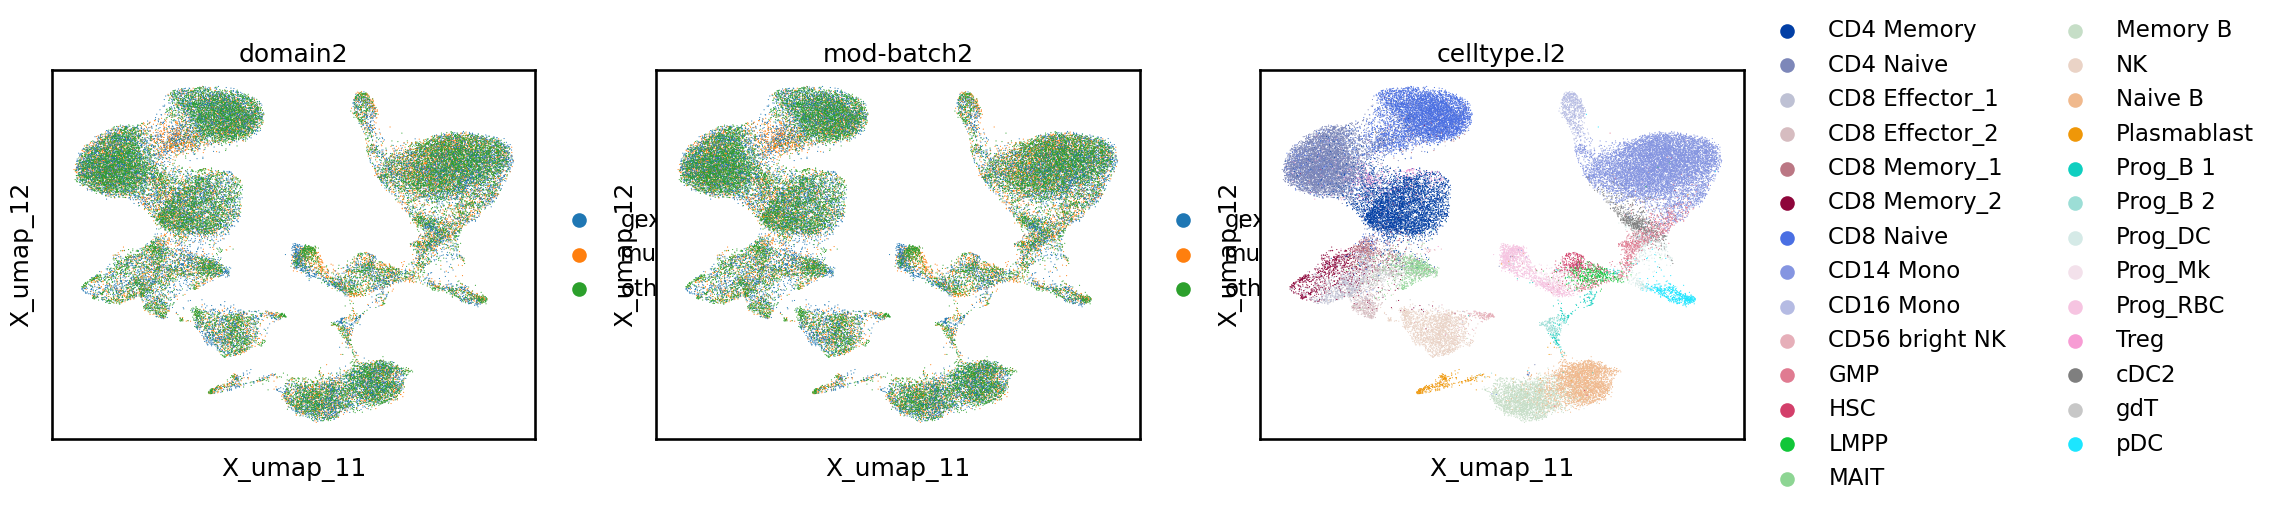

In [35]:
sc.pl.embedding(ad_mosaic, basis='X_umap_1', color=['domain2', 'mod-batch2', 'celltype.l2'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


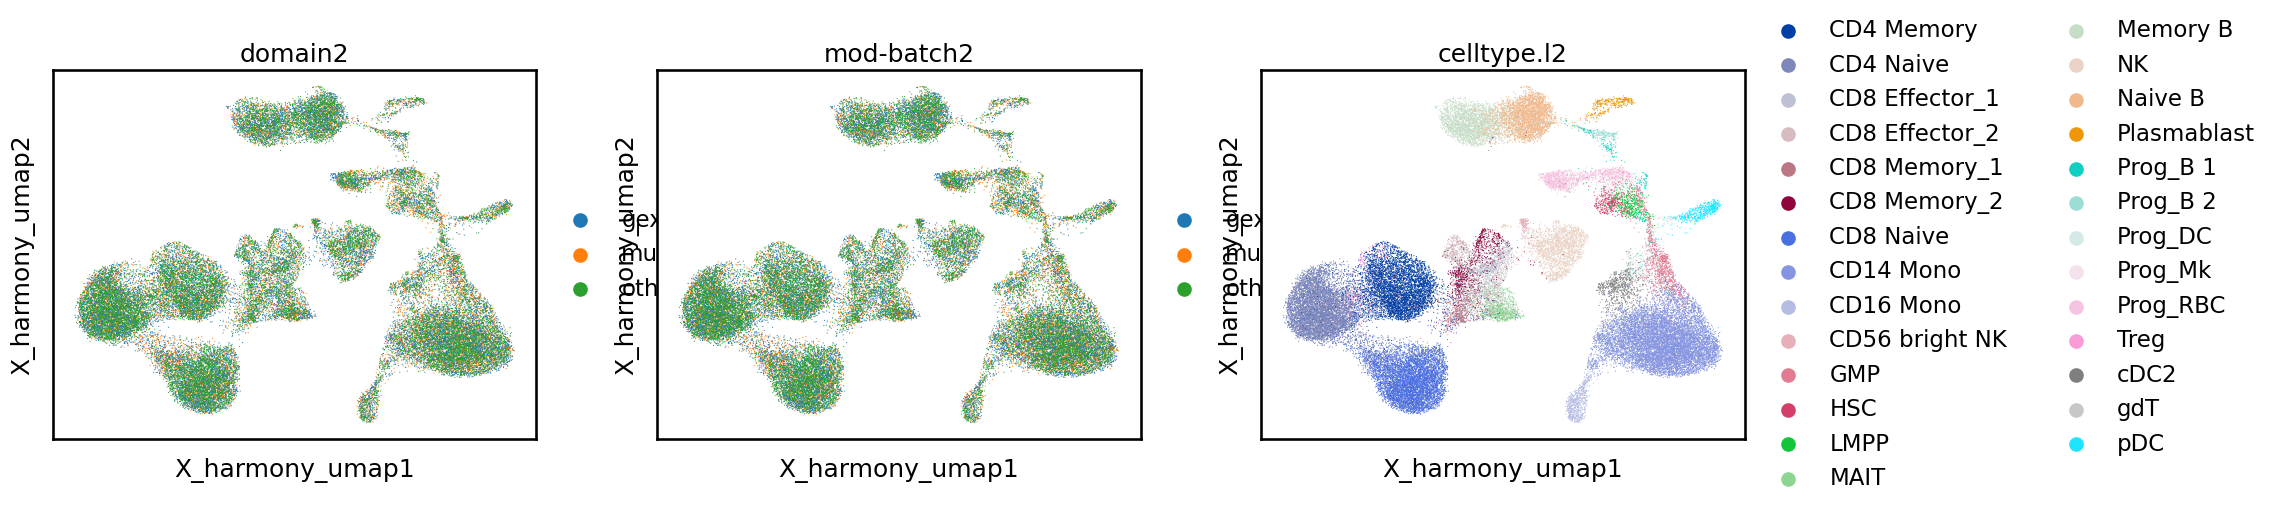

In [36]:
sc.pl.embedding(ad_mosaic, basis='X_harmony_umap', color=['domain2', 'mod-batch2', 'celltype.l2'], legend_loc='right margin')

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/t

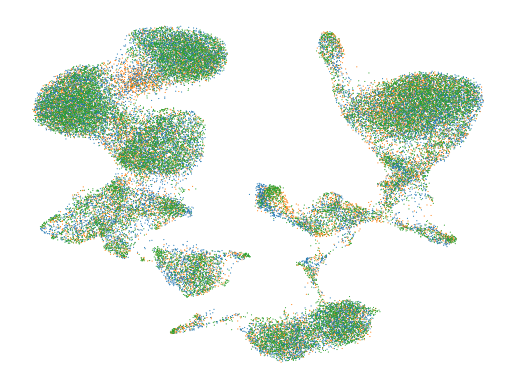

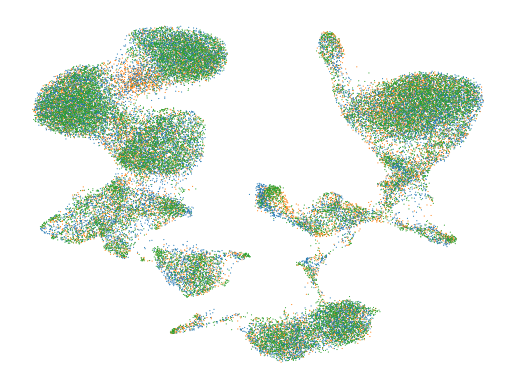

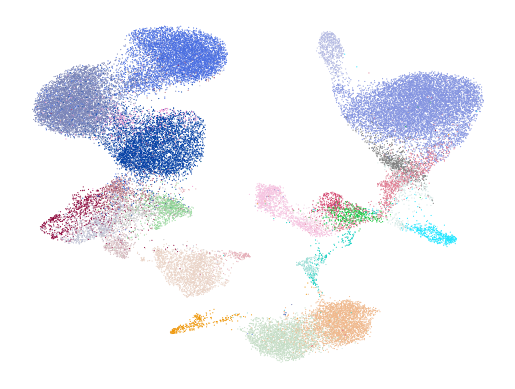

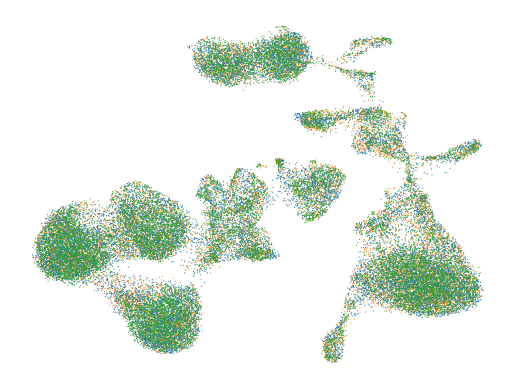

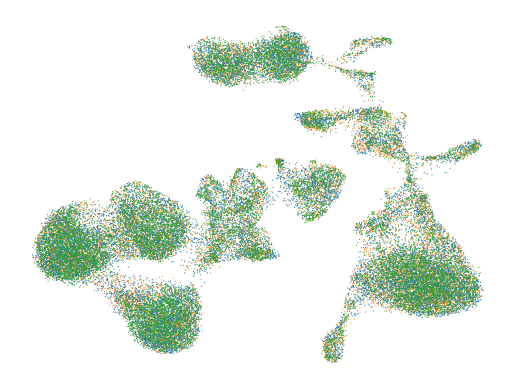

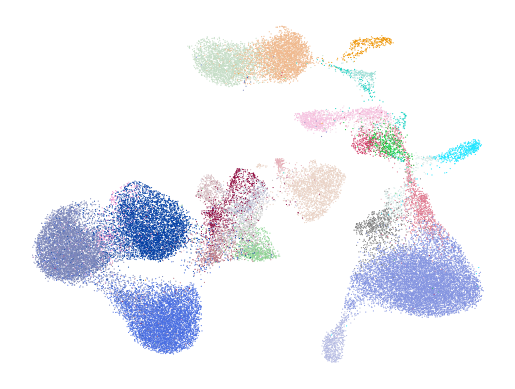

In [37]:
save_umap(ad_mosaic, 'X_umap_1', ['domain2', 'mod-batch2', 'celltype.l2'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='clue_case1_bm-cite')

save_umap(ad_mosaic, 'X_harmony_umap', ['domain2', 'mod-batch2', 'celltype.l2'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='clue-harmony_case1_bm-cite')

In [38]:
np.save(join(umap_save_dir, 'clue_case1_bm-cite_umap.npy'), ad_mosaic.obsm['X_umap_1'])
np.save(join(umap_save_dir, 'clue-harmony_case1_bm-cite_umap.npy'), ad_mosaic.obsm['X_harmony_umap'])